## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

The Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train an SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

### Load the dataset

In [1]:
import os
import glob
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


positive_files = glob.glob( "data/vehicles/*/*.png", recursive=True)
negative_files = glob.glob( "data/non-vehicles/*/*.png", recursive=True)
files = positive_files + negative_files

y = np.ones(len(files))
y[len(positive_files):] = 2


print("# of car/non-car images = %d / %d", (len(positive_files), len(negative_files)))

# of car/non-car images = %d / %d (8792, 8968)


### Extract features

Extract HOG, spatial and color histograms.

In [2]:
# extract features
from skimage.feature import hog
from skimage.exposure import histogram
pix_per_cell = 8
cell_per_block = 2
orient = 9
hist_bins = 32
spatial_size=(32, 32)
USE_SPATIAL_FEATURE = True

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #1) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        #print('spatial_features ', spatial_features.shape)
        
    #2) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        #print('hist features ', hist_features.shape)
        
    #3) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        image = mpimg.imread(file)     
        feature_tmp = single_img_features(image, color_space, spatial_size,hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,spatial_feat, hist_feat, hog_feat)
        features.append( feature_tmp )
    features = np.asarray(features)
    return features


X_all = extract_features(files,'YCrCb',spatial_size,
                         hist_bins,orient,pix_per_cell,cell_per_block, 'ALL',
                         USE_SPATIAL_FEATURE, True, True)
print("# of features for each iamge = ",X_all.shape[1])

# of features for each iamge =  8460


### Scale the data

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_all)
X_all_scaled = X_scaler.transform(X_all)

X_train, X_test, y_train, y_test = train_test_split( X_all_scaled, y, test_size=0.33, random_state=42)

### Train SVM classifier

In [4]:
# SVM 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,n_jobs=7,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}

Grid scores on development set:

0.881 (+/-0.017) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.993 (+/-0.004) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}
0.885 (+/-0.015) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.995 (+/-0.002) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.885 (+/-0.015) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}
0.995 (+/-0.002) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 100}
0.885 (+/-0.015) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1000}
0.995 (+/-0.002) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1000}
0.988 (+/-0.001) for {'kernel': 'linear', 'C': 1}
0.988 (+/-0.001) for {'kernel': 'linear', 'C': 10}
0.988 (+/-0.001) for {'kernel': 'linear', 'C': 100}
0.988 (+/-0.001) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed 

In [5]:
# SVM 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib
# Train the classifier
clf = SVC(kernel='rbf', gamma = 0.0001,C = 10)
t=time.time()
clf.fit(X_train, y_train) 
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVM...')
joblib.dump(clf, 'car_detector.pkl') 


# Check the score of the SVC
print('Train Accuracy of SVC = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

169.33 Seconds to train SVM...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9957
             precision    recall  f1-score   support

        1.0       1.00      0.99      1.00      2887
        2.0       0.99      1.00      1.00      2974

avg / total       1.00      1.00      1.00      5861



### Hog Sub-sampling Window Search

Now lets explore a more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. The code below defines a single function find_cars that's able to both extract features and make predictions.

The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.


In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            #f = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = np.hstack((spatial_features,hist_features, hog_features)).reshape(1, -1)
            # Scale features and make a prediction
            test_features = X_scaler.transform( test_features )    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1: # Is a car                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                bbox_list.append( bbox )
    return draw_img, bbox_list

Results on the test images

[]


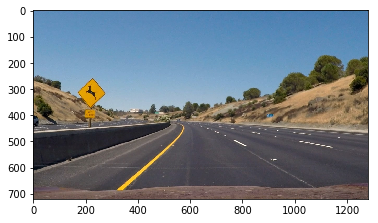

[[(864, 400), (960, 496)], [(888, 400), (984, 496)]]


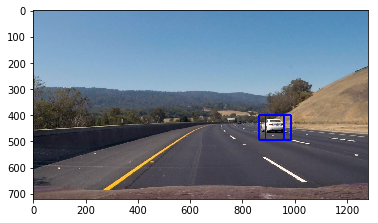

[[(792, 400), (888, 496)], [(816, 400), (912, 496)], [(816, 424), (912, 520)], [(840, 400), (936, 496)], [(864, 400), (960, 496)], [(864, 424), (960, 520)], [(1032, 400), (1128, 496)], [(1032, 424), (1128, 520)], [(1056, 400), (1152, 496)], [(1056, 424), (1152, 520)], [(1104, 400), (1200, 496)], [(1104, 424), (1200, 520)], [(1128, 400), (1224, 496)], [(1128, 424), (1224, 520)], [(1152, 400), (1248, 496)], [(1152, 424), (1248, 520)]]


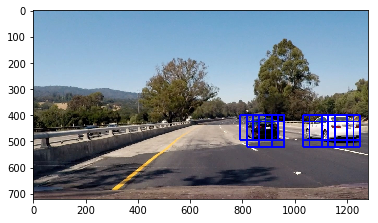

[[(792, 400), (888, 496)], [(816, 400), (912, 496)], [(840, 400), (936, 496)], [(840, 424), (936, 520)], [(864, 400), (960, 496)], [(1056, 400), (1152, 496)], [(1056, 424), (1152, 520)], [(1104, 424), (1200, 520)], [(1128, 424), (1224, 520)], [(1152, 424), (1248, 520)]]


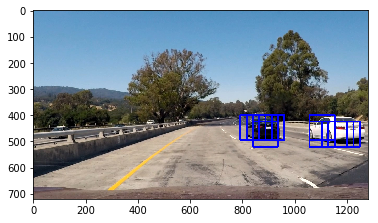

[[(744, 400), (840, 496)], [(768, 400), (864, 496)], [(792, 400), (888, 496)], [(816, 400), (912, 496)], [(840, 400), (936, 496)], [(840, 424), (936, 520)], [(864, 400), (960, 496)], [(1080, 400), (1176, 496)], [(1080, 424), (1176, 520)], [(1104, 400), (1200, 496)], [(1104, 424), (1200, 520)], [(1152, 424), (1248, 520)]]


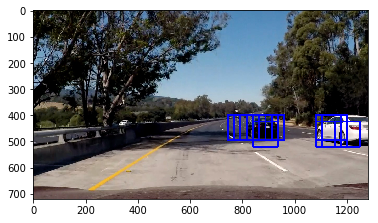

[[(792, 400), (888, 496)], [(816, 400), (912, 496)], [(816, 424), (912, 520)], [(840, 400), (936, 496)], [(840, 424), (936, 520)], [(864, 400), (960, 496)], [(864, 424), (960, 520)], [(1008, 400), (1104, 496)], [(1008, 424), (1104, 520)], [(1032, 400), (1128, 496)], [(1056, 400), (1152, 496)], [(1056, 424), (1152, 520)], [(1080, 400), (1176, 496)], [(1080, 424), (1176, 520)], [(1104, 400), (1200, 496)], [(1104, 424), (1200, 520)], [(1128, 424), (1224, 520)]]


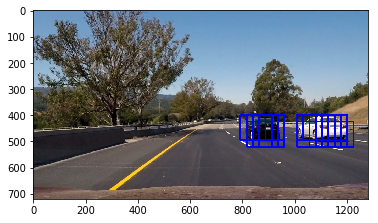

In [7]:
ystart = 400
ystop = 656
scale = 1.5
# Load the test image and perform undistortion
files = glob.glob( "./test_images/*.jpg")
imgs_test = []
#bbox_list = []
for fn in files:
    img = mpimg.imread(fn)
    out_img,bbox_list = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #print (bbox_list)
    plt.imshow(out_img)
    plt.show()



### Multiple Detections & False Positives

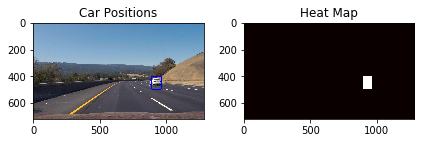

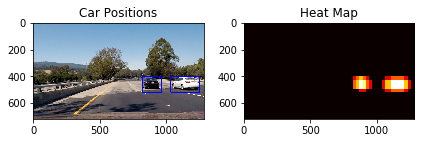

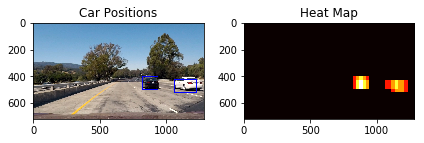

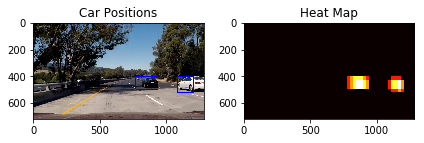

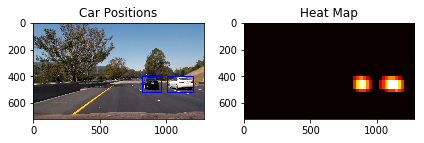

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_image(image):
    out_img,bbox_list = find_cars(image, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(bbox_list) == 0 :
        return image
    #print (bbox_list)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    #fig = plt.figure()
    #plt.imshow(draw_img)
    #plt.show()
    return draw_img
    

for fn in files:
    img = mpimg.imread(fn)
    out_img,bbox_list = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(bbox_list) == 0 :
        continue
    #print (bbox_list)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()


Test the algorithms on videos

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# process the videos
white_output = 'project_video_results.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_results.mp4
[MoviePy] Writing video project_video_results.mp4


100%|█████████▉| 1260/1261 [1:32:32<00:04,  4.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_results.mp4 

CPU times: user 1h 33min 5s, sys: 1.4 s, total: 1h 33min 7s
Wall time: 1h 32min 32s


In [10]:
# process the videos
white_output = 'test_video_results.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_results.mp4
[MoviePy] Writing video test_video_results.mp4


 97%|█████████▋| 38/39 [02:51<00:04,  4.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_results.mp4 

CPU times: user 2min 52s, sys: 76 ms, total: 2min 52s
Wall time: 2min 52s


## [Option]Code for generating report images
The remainning code are utilized to generalize dispalying images for the report ONLY! The essential functions are defined and tested aforementioned.

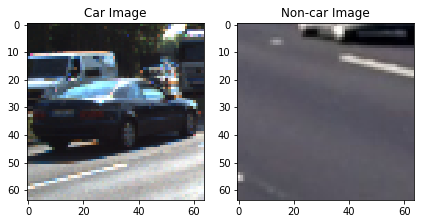

In [13]:
# Get the first image of positive and negative examples
img_pos = mpimg.imread( positive_files[2] )
img_neg = mpimg.imread( negative_files[2] )
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_pos)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(img_neg)
plt.title('Non-car Image')
fig.tight_layout()
plt.show()

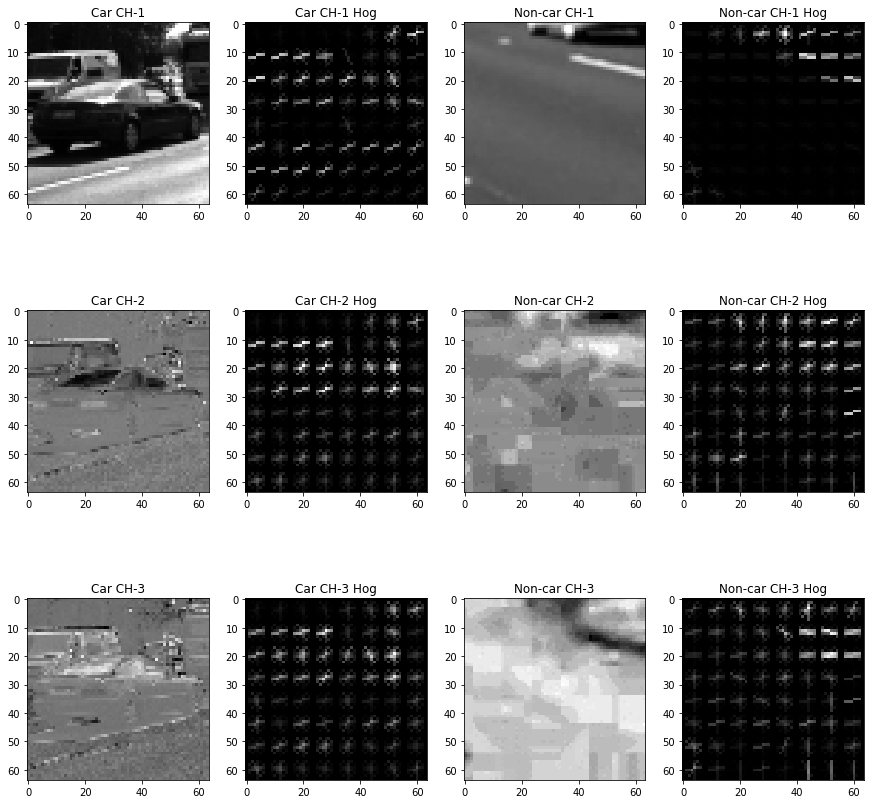

In [33]:
img_pos_ycrcb = convert_color(img_pos)
img_neg_ycrcb = convert_color(img_neg)

hog_feature_pos1, hog_pos1 = get_hog_features(img_pos_ycrcb[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_feature_pos2, hog_neg1 = get_hog_features(img_neg_ycrcb[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)

hog_feature_pos1, hog_pos2 = get_hog_features(img_pos_ycrcb[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_feature_pos2, hog_neg2 = get_hog_features(img_neg_ycrcb[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)


hog_feature_pos1, hog_pos3 = get_hog_features(img_pos_ycrcb[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
hog_feature_pos2, hog_neg3 = get_hog_features(img_neg_ycrcb[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)


f, axarr = plt.subplots(3, 4)
f.set_figheight(15)
f.set_figwidth(15)
# channel 1
axarr[0,0].imshow(img_pos_ycrcb[:,:,0], cmap='gray')
axarr[0,0].set_title('Car CH-1')
axarr[0,1].imshow(hog_pos1, cmap='gray')
axarr[0,1].set_title('Car CH-1 Hog')
axarr[0,2].imshow(img_neg_ycrcb[:,:,0], cmap='gray')
axarr[0,2].set_title('Non-car CH-1')
axarr[0,3].imshow(hog_neg1, cmap='gray')
axarr[0,3].set_title('Non-car CH-1 Hog')

# channel 2
axarr[1,0].imshow(img_pos_ycrcb[:,:,1], cmap='gray')
axarr[1,0].set_title('Car CH-2')
axarr[1,1].imshow(hog_pos2, cmap='gray')
axarr[1,1].set_title('Car CH-2 Hog')
axarr[1,2].imshow(img_neg_ycrcb[:,:,1], cmap='gray')
axarr[1,2].set_title('Non-car CH-2')
axarr[1,3].imshow(hog_neg2, cmap='gray')
axarr[1,3].set_title('Non-car CH-2 Hog')

# channel 3
axarr[2,0].imshow(img_pos_ycrcb[:,:,2], cmap='gray')
axarr[2,0].set_title('Car CH-3')
axarr[2,1].imshow(hog_pos3, cmap='gray')
axarr[2,1].set_title('Car CH-3 Hog')
axarr[2,2].imshow(img_neg_ycrcb[:,:,2], cmap='gray')
axarr[2,2].set_title('Non-car CH-3')
axarr[2,3].imshow(hog_neg3, cmap='gray')
axarr[2,3].set_title('Non-car CH-3 Hog')
plt.show()

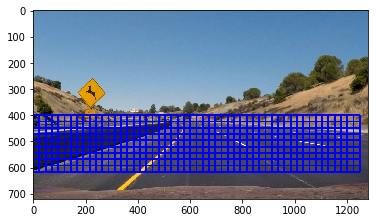

In [29]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_slide_window(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                         
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    return draw_img, bbox_list

ystart = 400
ystop = 656
scale = 1.5
# Load the test image and perform undistortion
files = glob.glob( "./test_images/*.jpg")
imgs_test = []
#bbox_list = []
for fn in files:
    img = mpimg.imread(fn)
    out_img,bbox_list = find_cars_slide_window(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #print (bbox_list)
    plt.imshow(out_img)
    plt.show()
    break
    


4.54 Seconds to detect a car. 
4.84 Seconds to detect a car. 
4.51 Seconds to detect a car. 
4.43 Seconds to detect a car. 
4.41 Seconds to detect a car. 
4.4 Seconds to detect a car. 


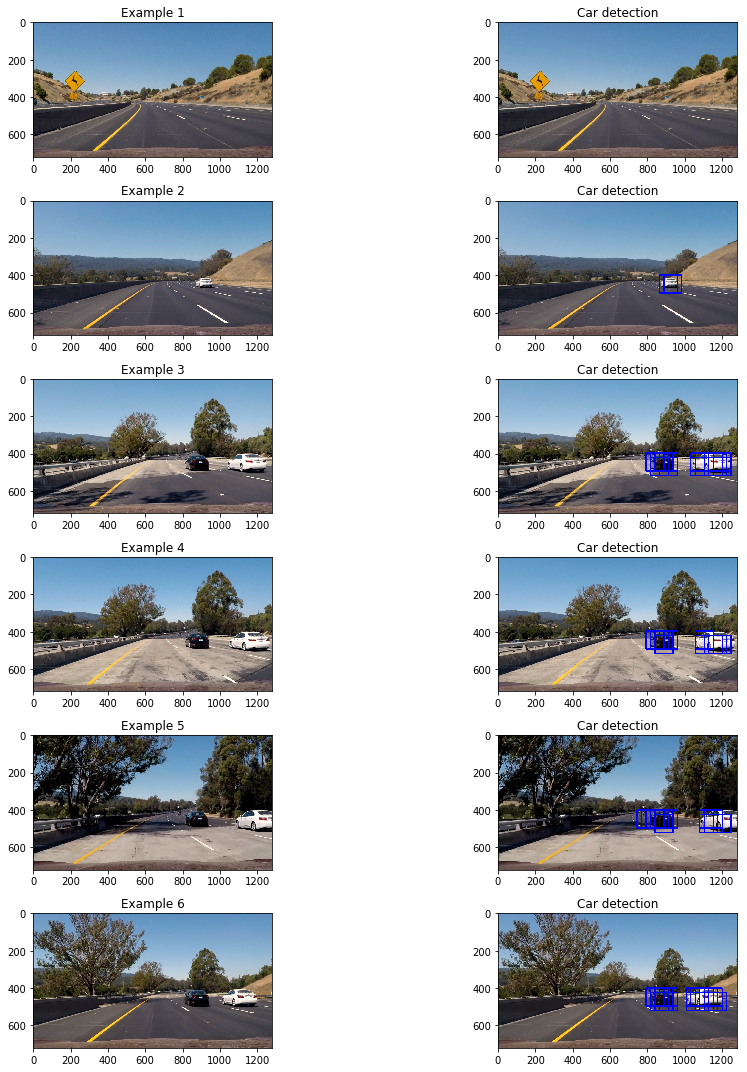

In [36]:
test_results = []
test_imgs = []
for fn in files:
    img = mpimg.imread(fn)
    t=time.time()
    out_img,bbox_list = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to detect a car. ')
    test_results.append( out_img )
    test_imgs.append(img)
    
    
f, axarr = plt.subplots(6, 2)
f.set_figheight(15)
f.set_figwidth(15)
# channel 1
axarr[0,0].imshow(test_imgs[0])
axarr[0,0].set_title('Example 1')
axarr[0,1].imshow(test_results[0])
axarr[0,1].set_title('Car detection')

axarr[1,0].imshow(test_imgs[1])
axarr[1,0].set_title('Example 2')
axarr[1,1].imshow(test_results[1])
axarr[1,1].set_title('Car detection')

axarr[2,0].imshow(test_imgs[2])
axarr[2,0].set_title('Example 3')
axarr[2,1].imshow(test_results[2])
axarr[2,1].set_title('Car detection')

axarr[3,0].imshow(test_imgs[3])
axarr[3,0].set_title('Example 4')
axarr[3,1].imshow(test_results[3])
axarr[3,1].set_title('Car detection')

axarr[4,0].imshow(test_imgs[4])
axarr[4,0].set_title('Example 5')
axarr[4,1].imshow(test_results[4])
axarr[4,1].set_title('Car detection')

axarr[5,0].imshow(test_imgs[5])
axarr[5,0].set_title('Example 6')
axarr[5,1].imshow(test_results[5])
axarr[5,1].set_title('Car detection')
f.tight_layout()
plt.show()

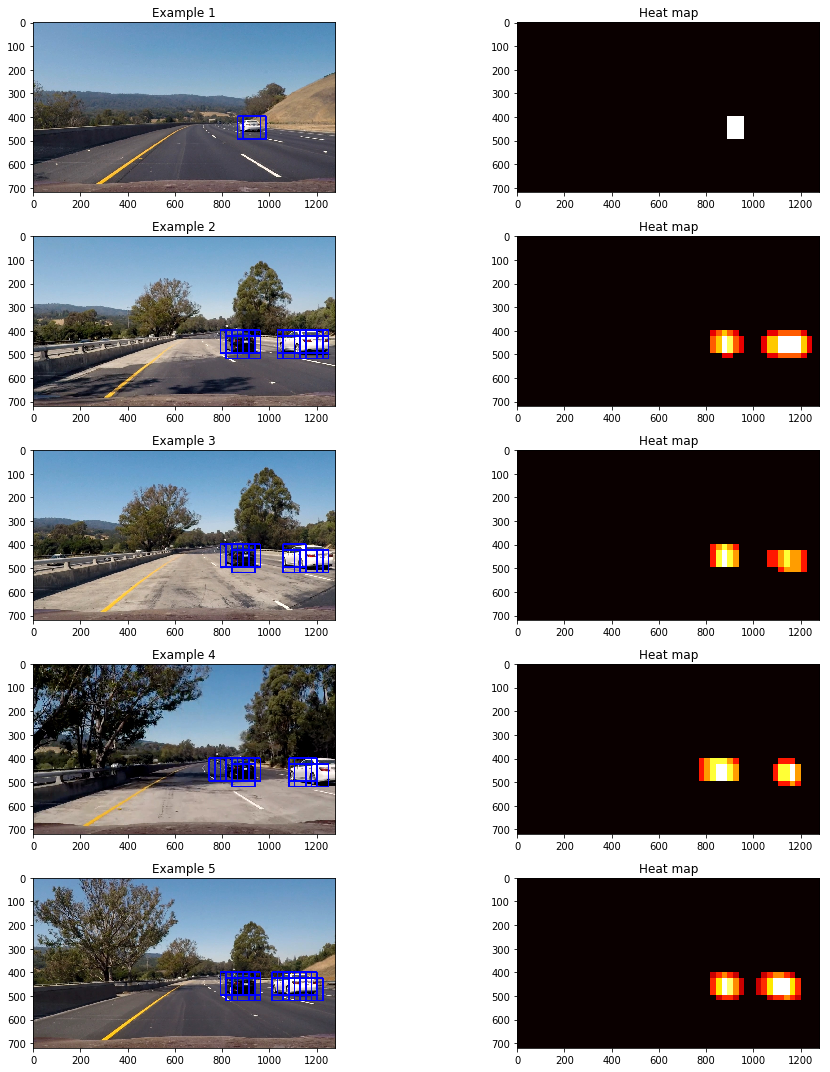

In [41]:
test_imgs = []
test_heatmap = []
for fn in files:
    img = mpimg.imread(fn)
    out_img,bbox_list = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if len(bbox_list) == 0 :
        continue
    #print (bbox_list)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    test_imgs.append(out_img)
    test_heatmap.append(heatmap);

       
f, axarr = plt.subplots(5, 2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0,0].imshow(test_imgs[0])
axarr[0,0].set_title('Example 1')
axarr[0,1].imshow(test_heatmap[0], cmap='hot')
axarr[0,1].set_title('Heat map')

axarr[1,0].imshow(test_imgs[1])
axarr[1,0].set_title('Example 2')
axarr[1,1].imshow(test_heatmap[1], cmap='hot')
axarr[1,1].set_title('Heat map')

axarr[2,0].imshow(test_imgs[2])
axarr[2,0].set_title('Example 3')
axarr[2,1].imshow(test_heatmap[2], cmap='hot')
axarr[2,1].set_title('Heat map')

axarr[3,0].imshow(test_imgs[3])
axarr[3,0].set_title('Example 4')
axarr[3,1].imshow(test_heatmap[3], cmap='hot')
axarr[3,1].set_title('Heat map')

axarr[4,0].imshow(test_imgs[4])
axarr[4,0].set_title('Example 5')
axarr[4,1].imshow(test_heatmap[4], cmap='hot')
axarr[4,1].set_title('Heat map')

f.tight_layout()
plt.show()

4.68 Seconds to detect a car. 
4.54 Seconds to detect a car. 
4.46 Seconds to detect a car. 
4.42 Seconds to detect a car. 
4.51 Seconds to detect a car. 
4.46 Seconds to detect a car. 


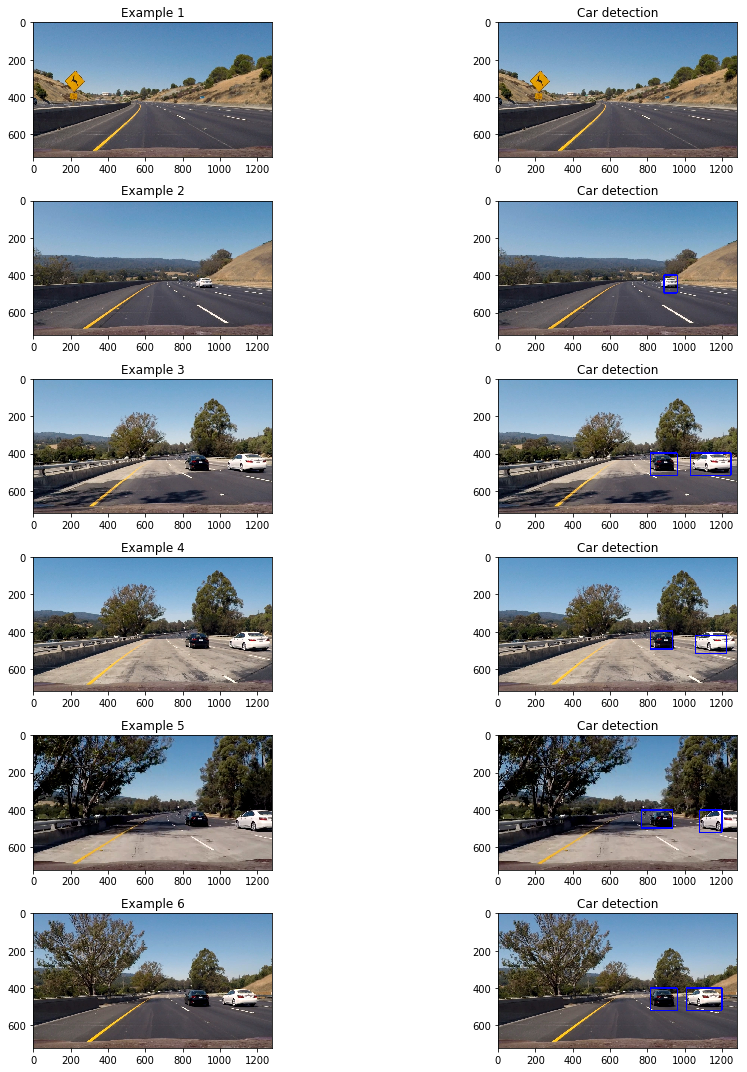

In [42]:
test_results = []
test_imgs = []
for fn in files:
    img = mpimg.imread(fn)
    t=time.time()
    out_img = process_image(img)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to detect a car. ')
    test_results.append( out_img )
    test_imgs.append(img)
    
    
f, axarr = plt.subplots(6, 2)
f.set_figheight(15)
f.set_figwidth(15)
# channel 1
axarr[0,0].imshow(test_imgs[0])
axarr[0,0].set_title('Example 1')
axarr[0,1].imshow(test_results[0])
axarr[0,1].set_title('Car detection')

axarr[1,0].imshow(test_imgs[1])
axarr[1,0].set_title('Example 2')
axarr[1,1].imshow(test_results[1])
axarr[1,1].set_title('Car detection')

axarr[2,0].imshow(test_imgs[2])
axarr[2,0].set_title('Example 3')
axarr[2,1].imshow(test_results[2])
axarr[2,1].set_title('Car detection')

axarr[3,0].imshow(test_imgs[3])
axarr[3,0].set_title('Example 4')
axarr[3,1].imshow(test_results[3])
axarr[3,1].set_title('Car detection')

axarr[4,0].imshow(test_imgs[4])
axarr[4,0].set_title('Example 5')
axarr[4,1].imshow(test_results[4])
axarr[4,1].set_title('Car detection')

axarr[5,0].imshow(test_imgs[5])
axarr[5,0].set_title('Example 6')
axarr[5,1].imshow(test_results[5])
axarr[5,1].set_title('Car detection')
f.tight_layout()
plt.show()